# Importing libraries

In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
from shapeGMM import gmm_shapes
import os
import sys
import pickle
import glob
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Read Trajectory and select alpha carbons only 

topol:  <mdtraj.Topology with 1 chains, 375 residues, 5835 atoms, 5870 bonds>
375
2001
4001


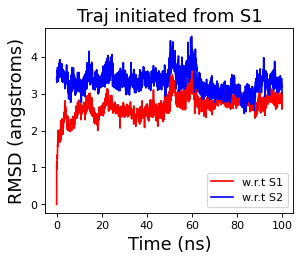

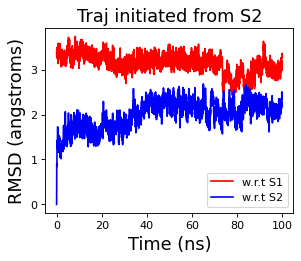

In [2]:
import mdtraj as mdt
data_path = "/scratch/projects/hockygroup/ss12902/posLDA_actin/md_sim_data/"

# load ref structures 
s1_ref = mdt.load(data_path+"s1_init_protein_only.gro")
s2_ref = mdt.load(data_path+"s2_init_protein_only.gro")

# topol
topol = s1_ref.topology
print("topol: ", topol)

# select CA atoms only
ca_atoms = [atom.index for atom in topol.atoms if atom.name == "CA"]
print(len(ca_atoms))
#print("ca_atoms: ", ca_atoms)

# load trajs 
s1_traj = mdt.load(data_path+"ActinS1_100ns_wrpd_cntr.trr", top=topol, atom_indices=ca_atoms)
s2_traj = mdt.load(data_path+"ActinS2_100ns_wrpd_cntr.trr", top=topol, atom_indices=ca_atoms)

print(s1_traj.n_frames)
print(s2_traj.n_frames)


# rmsd for s1_traj 
s1_traj_r1 = mdt.rmsd(s1_traj, s1_ref, atom_indices=np.arange(len(ca_atoms)), ref_atom_indices=ca_atoms)*10.0
s1_traj_r2 = mdt.rmsd(s1_traj, s2_ref, atom_indices=np.arange(len(ca_atoms)), ref_atom_indices=ca_atoms)*10.0

plt.figure(figsize=(4,3), dpi=80)
plt.title("Traj initiated from S1", fontsize=16)
plt.xlabel("Time (ns)", fontsize=16)
plt.ylabel("RMSD (angstroms)", fontsize=16)
plt.plot(s1_traj.time*1e-3, s1_traj_r1, "r-", label="w.r.t S1")
plt.plot(s1_traj.time*1e-3, s1_traj_r2, "b-", label="w.r.t S2")
plt.legend(fontsize="medium")

# rmsd for s2_traj 
s2_traj_r1 = mdt.rmsd(s2_traj, s1_ref, atom_indices=np.arange(len(ca_atoms)), ref_atom_indices=ca_atoms)*10.0
s2_traj_r2 = mdt.rmsd(s2_traj, s2_ref, atom_indices=np.arange(len(ca_atoms)), ref_atom_indices=ca_atoms)*10.0

plt.figure(figsize=(4,3), dpi=80)
plt.title("Traj initiated from S2", fontsize=16)
plt.xlabel("Time (ns)", fontsize=16)
plt.ylabel("RMSD (angstroms)", fontsize=16)
plt.plot(s2_traj.time*1e-3, s2_traj_r1, "r-", label="w.r.t S1")
plt.plot(s2_traj.time*1e-3, s2_traj_r2, "b-", label="w.r.t S2")
plt.legend(fontsize="medium")

In [7]:
print(s1_traj.time[-1], "|", s1_traj.n_frames)
print(s2_traj.time[-1], "|", s2_traj.n_frames)

100000.0 | 2001
100000.0 | 4001


In [3]:
x = np.array(ca_atoms)+1
line = ",".join(np.array(x, dtype=str))
print(line)

9,21,36,48,63,77,91,101,120,136,147,159,173,180,191,198,217,233,255,265,272,292,302,309,321,333,345,357,381,391,407,429,441,452,471,487,494,520,532,556,573,590,597,613,630,646,653,670,677,694,716,728,739,760,776,783,795,810,820,837,848,870,894,901,920,939,953,972,994,1017,1029,1048,1063,1084,1091,1110,1129,1143,1157,1181,1193,1205,1222,1237,1259,1278,1302,1319,1336,1350,1370,1391,1405,1420,1439,1463,1479,1491,1503,1518,1533,1552,1564,1578,1597,1616,1630,1645,1657,1669,1688,1704,1716,1738,1748,1762,1786,1801,1823,1840,1854,1871,1890,1907,1927,1942,1956,1976,1990,2008,2020,2030,2047,2068,2084,2094,2113,2130,2140,2156,2175,2186,2205,2226,2236,2247,2254,2278,2292,2306,2313,2332,2348,2367,2379,2390,2397,2409,2416,2432,2446,2463,2477,2495,2507,2526,2547,2562,2569,2590,2600,2621,2633,2650,2660,2679,2696,2720,2739,2751,2770,2780,2787,2811,2823,2842,2856,2868,2889,2908,2925,2947,2966,2985,2999,3014,3038,3045,3066,3077,3097,3113,3127,3141,3151,3166,3190,3205,3224,3240,3264,3276,3295,3317,3332,33

In [4]:
# concatenating two separate trajectories (using only 10ns data from each state)
data = np.concatenate([s1_traj.xyz[:200:], s2_traj.xyz[:200:,:,:]], axis=0)
print(data.shape)

trajData = np.empty(data.shape)

# align 
for i in range(data.shape[0]):
    x = data[i,:,:]
    com = np.mean(x, axis=0)
    trajData[i,:,:] = (x - com)

print(trajData)

(400, 375, 3)
[[[-2.75763488  0.79943562 -2.17326903]
  [-2.38473487  0.70683479 -2.11416674]
  [-2.18583727  0.45633125 -2.30676413]
  ...
  [-1.7714386  -2.15946627 -1.20196486]
  [-1.79093623 -2.33156896 -1.5425632 ]
  [-2.09733558 -2.54266858 -1.45666409]]

 [[-2.94623327  1.00622463 -1.87267733]
  [-2.59290218  0.88872194 -1.9361279 ]
  [-2.51753926  0.64192343 -2.20557404]
  ...
  [-1.71944213 -2.21822786 -1.27157044]
  [-1.78238726 -2.35196257 -1.6250124 ]
  [-1.7928853  -2.72420216 -1.51701379]]

 [[-2.69253159  1.14643431 -2.03038549]
  [-2.32098866  1.07478619 -2.10900187]
  [-2.16940117  0.73938465 -2.23701334]
  ...
  [-1.79936719 -2.04789877 -1.20072055]
  [-1.87067628 -2.20789933 -1.53987885]
  [-1.74160671 -2.55218697 -1.4333601 ]]

 ...

 [[-1.48041773 -1.82115173  1.45676136]
  [-1.63077736 -2.16596508  1.55167913]
  [-1.47804642 -2.35448456  1.25778008]
  ...
  [ 0.43387079 -2.40955257 -0.62992811]
  [ 0.42876577 -2.01214504 -0.66368341]
  [ 0.48364878 -1.83713818 -0.

In [5]:
print(trajData.shape)

(400, 375, 3)


# Get the average and precision for each state

In [ ]:
from shapeGMM import _traj_tools as traj_tools

_, s1_avg, s1_prec, _ = traj_tools.traj_iterative_average_precision_weighted_kabsch(trajData[:200:,:,:])
_, s2_avg, s2_prec, _ = traj_tools.traj_iterative_average_precision_weighted_kabsch(trajData[200::,:,:])

np.savetxt("s1_avg.txt", s1_avg)
np.savetxt("s1_prec.txt", s1_prec)

np.savetxt("s2_avg.txt", s2_avg)
np.savetxt("s2_prec.txt", s2_prec)

# Get the global average and precision 

In [ ]:
global_aligned_traj, global_avg, global_prec, _ = traj_tools.traj_iterative_average_precision_weighted_kabsch(trajData)

np.savetxt("global_avg.txt", global_avg)
np.savetxt("global_prec.txt", global_prec)

np.save("global_aligned_traj.npy", global_aligned_traj, allow_pickle=True)

In [6]:
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)

# Let's do the LDA calculation

In [7]:
# considering 0 == S1 and 1 == S2
labels = np.concatenate([np.zeros(200), np.ones(200)], axis=0)
print(labels.shape)

(400,)


In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
ld1 = lda.fit_transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], len(ca_atoms)*3), labels)[:,0]
print(ld1.shape)

(400,)


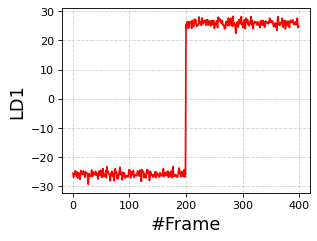

In [9]:
plt.figure(figsize=(4,3), dpi=80)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.xlabel("#Frame", fontsize=16)
plt.ylabel("LD1", fontsize=16)
plt.plot(ld1, 'r-', lw=1.5)

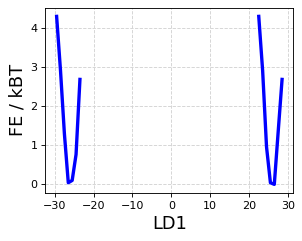

In [10]:
ld_range = [-30,30]
nbins = 60

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1, range=ld_range, bins=nbins, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

plt.figure(figsize=(4,3), dpi=80)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.xlabel("LD1", fontsize=16)
plt.ylabel("FE / kBT", fontsize=16)
plt.plot(grids, fe-fe.min(), 'b-', lw=3.0)

In [ ]:
# save lda coefficients for running simulations
print(lda.scalings_[:,0].shape)
np.savetxt("ld1_scalings.txt", lda.scalings_[:,0])

## compare the ld1 calculated from PLUMED 

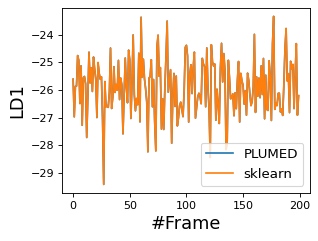

In [11]:
ld1_plumed = np.loadtxt("test_ld1.txt", usecols=1)[:200:]

plt.figure(figsize=(4,3), dpi=80)
plt.xlabel("#Frame", fontsize=16)
plt.ylabel("LD1", fontsize=16)
plt.plot(ld1_plumed, label="PLUMED")
plt.plot(ld1[:200:], label="sklearn")
plt.legend(fontsize="large")

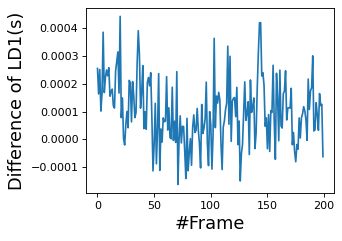

In [14]:
plt.figure(figsize=(4,3), dpi=80)
plt.xlabel("#Frame", fontsize=16)
plt.ylabel("Difference of LD1(s)", fontsize=16)
plt.plot(ld1_plumed - ld1[:200:])

## calculate the standard deviations of Ld1 corresponding to each state

In [15]:
s1_std = np.std(ld1[:200:])
s2_std = np.std(ld1[200::])

print("std dev of S1 =", s1_std)
print("std dev of S2 =", s2_std)

std dev of S1 = 0.9966170078179444
std dev of S2 = 0.998375951096584
